### Step 0 - Check available memory

In [48]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for i, gpu in enumerate(gpus):
        device_name = f"GPU:{i}"  # Properly format the device name
        details = tf.config.experimental.get_memory_info(device_name)
        print(f"GPU: {device_name}")
        print(f"Current Memory Usage: {details['current']} bytes")
        print(f"Peak Memory Usage: {details['peak']} bytes")
else:
    print("No GPU devices found.")

for gpu in gpus:
    print(f"Memory growth for {gpu}: {tf.config.experimental.get_memory_growth(gpu)}")

GPU: GPU:0
Current Memory Usage: 239643136 bytes
Peak Memory Usage: 4285265664 bytes
Memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): None


### Step 1 - Set up environment

In [49]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

### Step 3 - Data Exploration
Now that we have downloaded the dataset, let's try to explore & understand it!

Inside the `brats20-dataset-training-validation` folder, you will find two datasets: one for Training and one for Validation. If you open the `BraTS2020_TrainingData` folder, you will notice that it contains another folder, that contains 369 samples (which are patients here). 

#### Modalities & segmentation

Each sample includes:
- 4 different types of magnetic resonance imaging ***(MRI)*** scans of their brain, also known as ***modalities***, which are named ***T1***, ***T1ce***, ***T2*** and ***FLAIR***.
- The ground truth segmentation of the tumoral and non-tumoral regions of their brains, which has been manually realised by experts.

To better understand what we have, let's display these images:

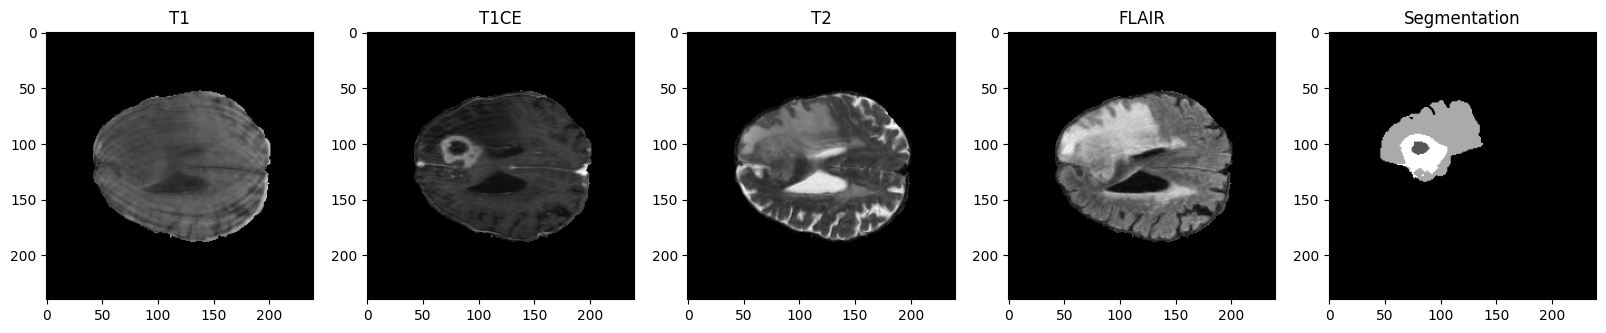

In [50]:
# Specify a sample path (here we will take the first patient of the Training dataset)
sample_path = '../brain_tumor_seg/data/raw_data/GLI_train/BraTS-GLI-00077-000/BraTS-GLI-00077-000-'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load(sample_path + 't1n.nii.gz')
t1ce_img=nib.load(sample_path + 't1c.nii.gz')
t2_img=nib.load(sample_path + 't2w.nii.gz')
flair_img=nib.load(sample_path + 't2f.nii.gz')
seg_img=nib.load(sample_path + 'seg.nii.gz')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

As you can see, the four modalities bring out **different aspects** for the same image.

To be more specific, here is a description of their interest:
- **Native T1 :** Used to show the structure and composition of different types of tissue in the brain and to identify tumors, cysts, and other abnormalities.
- **Post-contrast T1-weighted (T1ce, also named T1Gd) :** Similar to T1 images but with the injection of a contrast agent (Gadolinium) which will enhance the visibility of abnormalities.
- **T2-weighted (T2):** Used to show the fluid content of different types of tissue in the brain.
- **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery) :** Used to suppress this fluid content. This can be useful for identifying lesions that are not clearly visible on T1 or T2 images, and also for identifying lesions in the white matter of the brain, which can be difficult to see on other types of scans.

For an expert, it can be useful to have these 4 modalities in order to analyze the tumor more precisely, and to confirm its presence or not. 

But for our artificial approach, **using only two modalities instead of four** is interesting since it can reduce the computational and memory requirements of the segmentation task, making it faster and more efficient. That is why we will **exclude T1**, since we have its improved version T1ce. Also, we will **exclude the T2 modality**. Indeed, the fluids it presents could degrade our predictions. These fluids are removed in the flair version, which highlights the affected regions much better, and will therefore be much more interesting for our training.

#### Images format

You may have noticed that these images are in `.nii` format. Indeed, these scans are NIfTI files (*Neuroimaging Informatics Technology Initiative*). A NIfTI image is a digital representation of a 3D object, such as a brain in our case. To understand this more closely, let's display the shape of a modality scan and of a segmentation (they all have the same in this dataset): 

In [51]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


As you can see, modalities & segmentations do have 3 dimensions. Each dimension is composed of a series of two-dimensional images, known as **slices**, which all contain the same number of pixels, and are stacked together to create this 3D representation. That is why we have displayed 2D images just above (you may not have noticed but we have displayed the **100th slice** of a certain dimension, by setting the slice_nb = 100).

These 3 dimensions correspond to the three spatial dimensions of the image : width, height, and depth. In medical imaging, they are named **axial/transverse**, **coronal**, and **sagittal planes**, corresponding to the three main orientations of the human body, and therefore the human brain.

Here is a quick presentation of these 3 planes: 
 
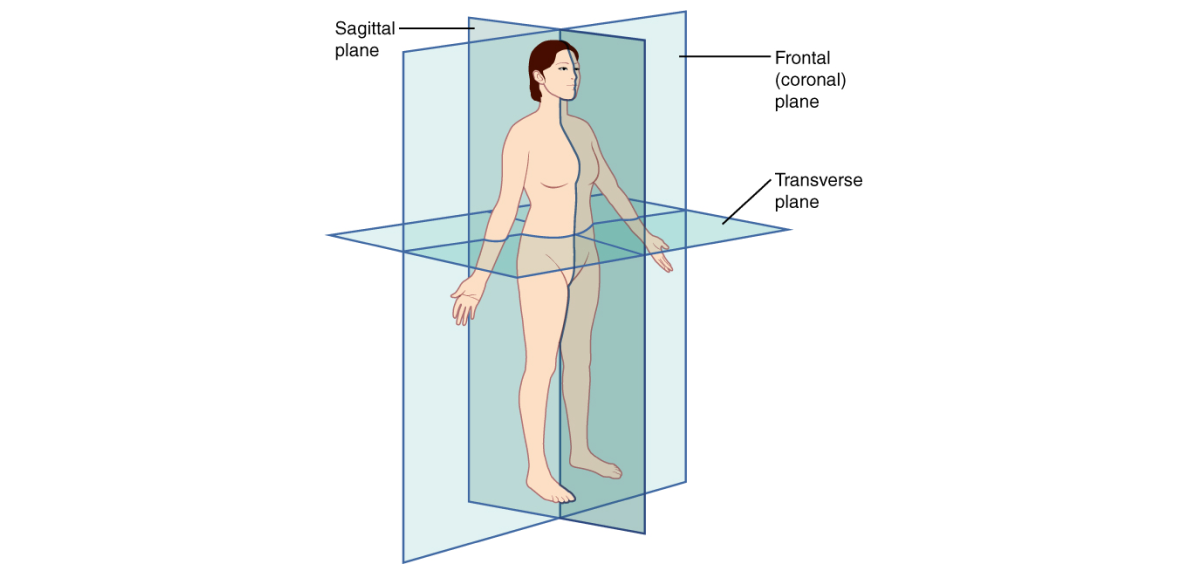
 
- **Sagittal Plane**: It divides the body into left and right sections and is often referred to as a "front-back" plane.

- **Coronal Plane**: It divides the body into front and back sections and is often referred to as a "side-side" plane.

- **Axial or Transverse Plane**: It divides the body into top and bottom sections and is often referred to as a "head-toe" plane.

So of course we can display each modality through its different planes. For example, we will display the 3 planes of the T1 image:

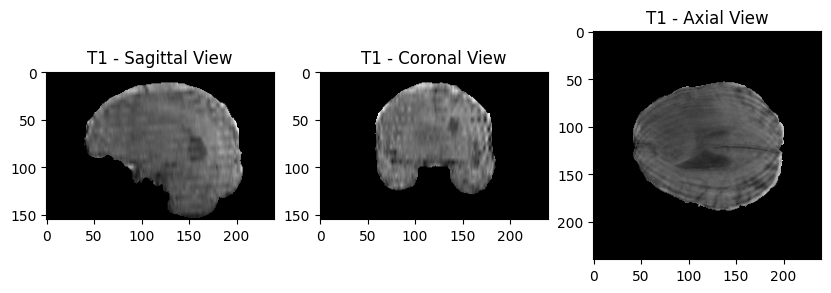

In [52]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

Now that we know why we have three dimensions, let's try to understand why we chose to display a specific slice, by fixing the `slice_nb` to 100. 

To do this, we will display all the slices: 

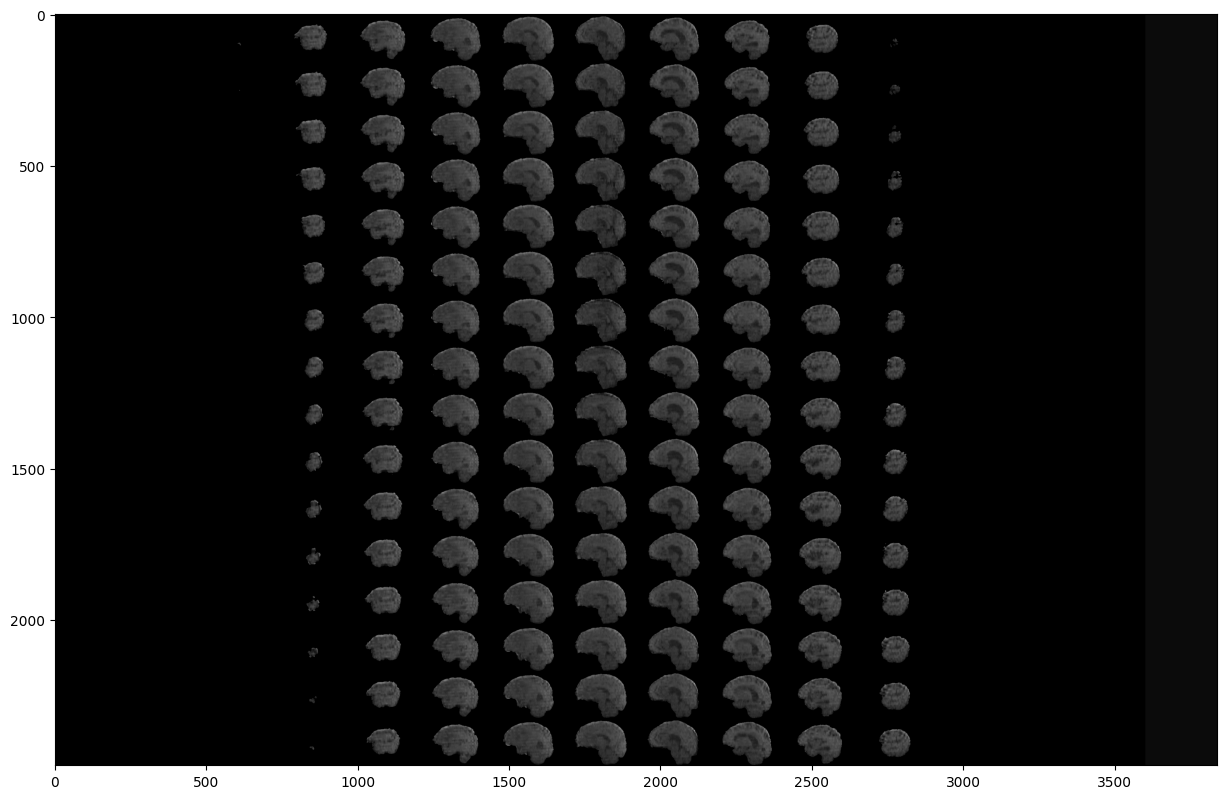

In [53]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')

# montage allows us to concatenate multiple images of the same size horizontally and vertically

As you can see, **two black parts** are present on each side of our montage. However, these **black parts correspond to the first and last slices** of a plane. This means that a large part of the slices does not contain much information. This is not surprising since the slices progressively represent the brain.

You will notice that this analysis is the same on all other modalities, all planes and also on the images segmented by the experts. Indeed, they were not able to segment the slices that do not contain much information.

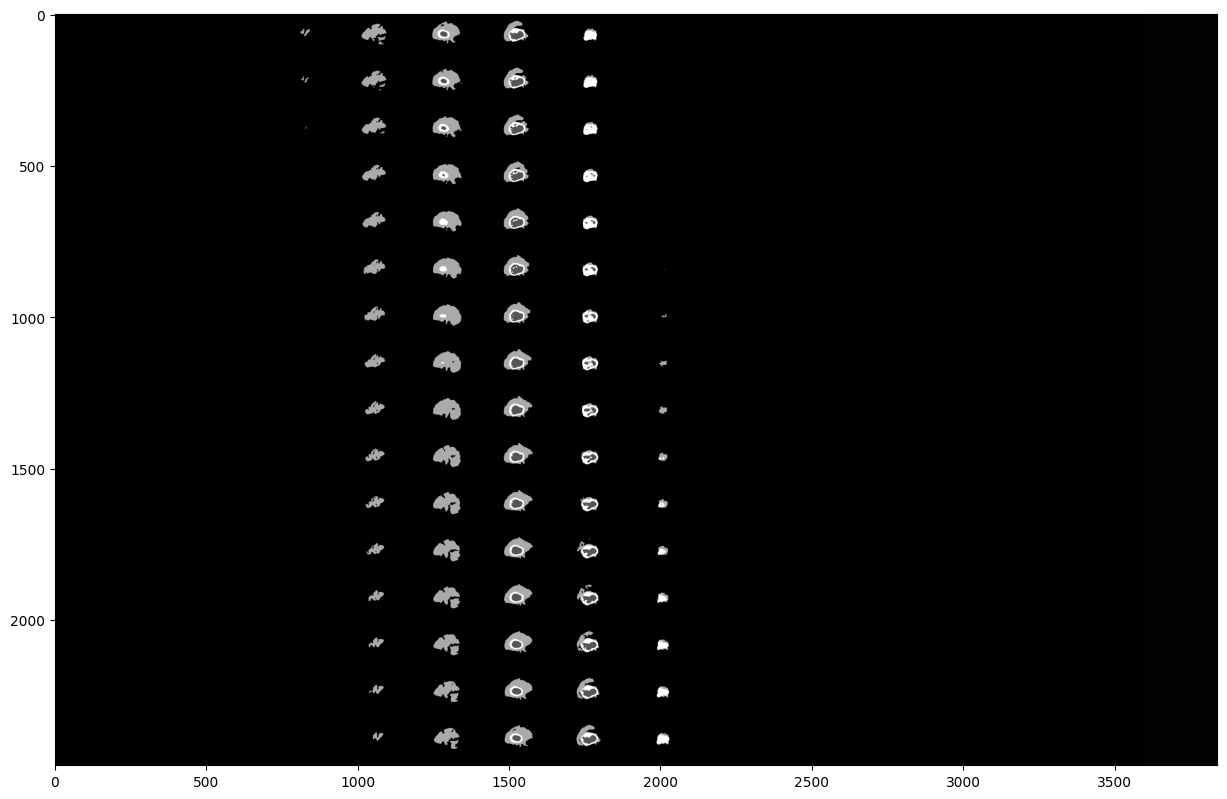

In [54]:
# Display all slices of a segmentation
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')

This is why we can exclude these slices in our analysis, in order to reduce the number of manipulated images. Indeed, you can see that **a (60:135) range will be much more interesting**:

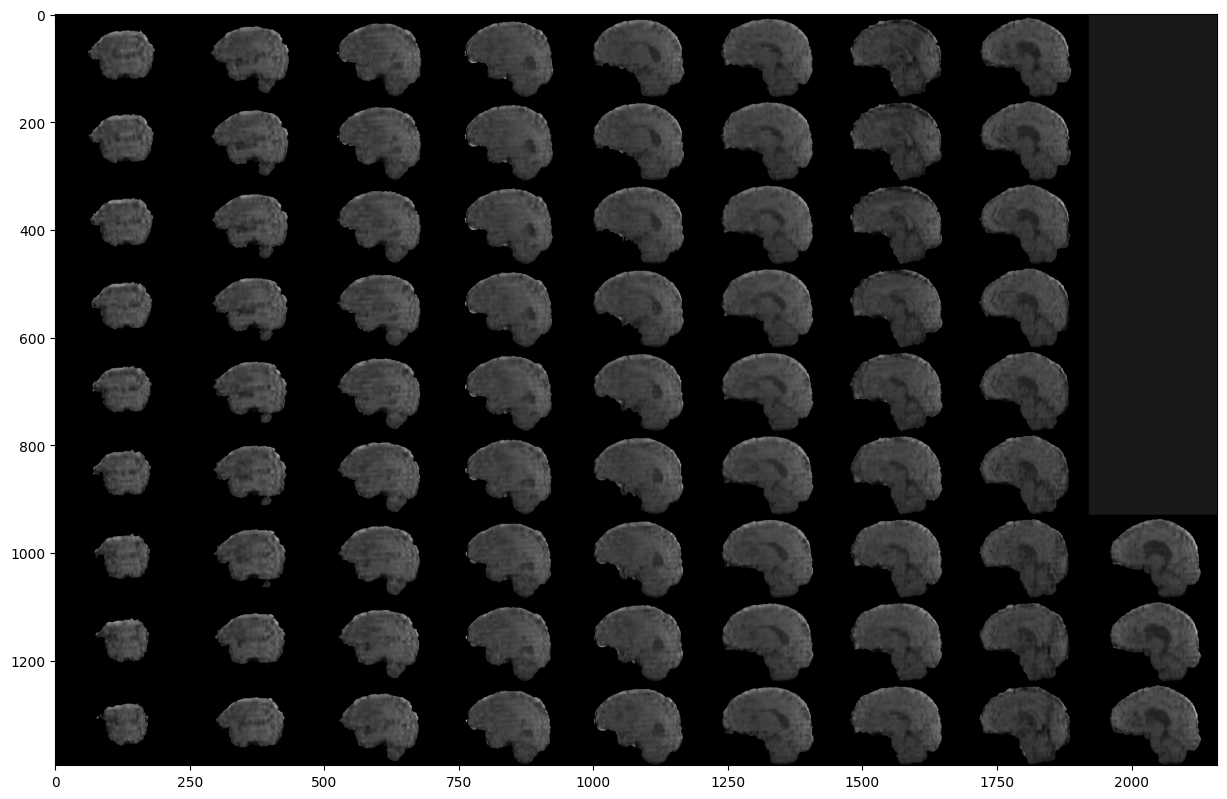

In [55]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')

Now, let's focus on the **segmentations** provided by the experts. What information do they give us? 

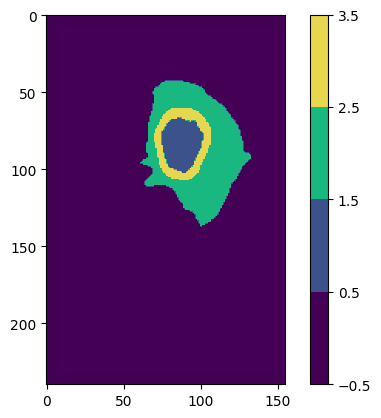

In [56]:
# Plot a segmantation
some_seg_img = nib.load("../brain_tumor_seg/data/raw_data/GLI_train/BraTS-GLI-00077-000/BraTS-GLI-00077-000-seg.nii.gz").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

Regardless of the plane you are viewing, you will notice that some slices have multiple colors (here 4 colors), which means that the experts have assigned multiple values to the segmentation. Let's see what values are possible in this dataset: 

*(Running this cell may take some time as we look at the values of all 369 segmentations in the dataset.)*

In [57]:
data_path = "../brain_tumor_seg/data/raw_data/GLI_train"
seg_samples = [os.path.join(data_path, sample, f"{sample}-seg.nii.gz") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))
    
    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

We notice that we have **4 possible values in the segmentation files**. These 4 values will form our 4 classes. Here is what they correspond to: 

- **0** : Not Tumor (NT) which means Healthy Zone or Background
- **1** : Necrotic and Non-Enhancing Tumor (NCR + NET)
- **2** : Peritumoral Edema (ED)
- **3** : Enhancing Tumor (ET)

Our goal is to predict and segment each of these 4 classes for new patients to find out whether or not they have a brain tumor and which areas are affected.

Let's now take a look at the distribution of these 4 values:

In [ ]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

We see that the previous segmentation has a lot of annotated data fixed to 0, which corresponds to the background (useless information). We might consider cropping our images to eliminate some of this useless area, to reduce the complexity of the segmentation task and thus speed up our training by reducing processing time.

Let's see what these 4 different classes correspond to, by displaying the classes one by one:

In [ ]:
# Deletion of class 0
seg_0 = some_seg_img.astype(float).copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.astype(float).copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.astype(float).copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.astype(float).copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

# Save the figure to a file
plt.savefig('segmentation_classes.png', dpi=300)  # Saves the image as 'segmentation_classes.png'

plt.show()

**To summarize data exploration:**

- We have for each sample / patient 4 different modalities (T1, T1CE, T2 & FLAIR), accompanied by a segmentation that indicates tumor areas.

- Modalities **T1CE** and **FLAIR** are the more interesting to keep, since these 2 provide complementary information about the anatomy and tissue contrast of the patient’s brain.

- Each image is 3D, and can therefore be analyzed through 3 different planes that are composed of 2D slices.

- Many slices contain little or no information. We will only **keep the (60:135)** slices interval for this tutorial. Of course, you are free to customize the code to send less or more slices to your model, but the training time will be longer.

- A segmentation image contains 1 to 4 classes. 

- Class number 4 must be reassigned to 3 since value 3 is missing. 

- Class 0 (background) is over-represented in the majority of the scans. However, cropping can remove important information. We will not use it in this tutorial and will keep the images as they are.

Now that we know more about our data, it is time to prepare the training of our model.

In [ ]:
# Define selected slices range
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

### Step 4 - Prepare data for Training

#### A - Split data into 3 sets
In the world of AI, the quality of a model is determined by its **ability to make accurate predictions on new, unseen data**. To achieve this, it is important to divide our data into three sets: **Training, Validation and Test**.

Reminder of their usefulness: 
- **Training set** is used to train the model. During training, the model is exposed to the training data and adjusts its parameters to minimize the error between its predictions and the Ground truth (segmentations).

- **Validation set** is used to fine-tune the hyperparameters of our model, which are set before training and determine the behavior of our model. The aim is to compare different hyperparameters and select the best configuration for our model.

- **Test set** is used to evaluate the performance of our model after it has been trained, to see how well it performs on unseen data.

As we said before, The BraTS2020 dataset is already divided in 2 folders: a training folder and a validation folder. 

Unfortunately, the validation folder does not contain the segmented data and therefore cannot be used. This is why we will ignore the samples that are in this folder and create our own validation set.

First, let's retrieve all samples that are present in the Training folder:

In [ ]:
# Specify path of our BraTS2020 directory
data_path = "../brain_tumor_seg/data/raw_data/GLI_train"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

We obtain 371 files while the braTS dataset contains only 369 samples. The reason is simple: 2 `.csv` files are present in the `MICCAI_BraTS2020_TrainingData` directory, indicated by the `data_path` variable, and have therefore been added to our samples list. So we are going to remove them: 

Now, let's create our 3 different sets: 

In [ ]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set 
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

#### B - Create a DataGenerator

In order to train a neural network to segment objects in images, it is necessary to feed it with both the raw image data (X) and the ground truth segmentations (y). By combining these two types of data, the neural network can learn to recognize tumor patterns and make accurate predictions about the contents of a patient’s scan.

Unfortunately, our modalities images (X) and our segmentations (y) cannot be sent directly to the AI model. Indeed, loading all these 3D images would overload the memory of our environment and cause the system to crash. This will also lead to shape mismatch errors. We have to do some image preprocessing before, which will be done by using a **Data Generator**, where we will **perform any operation** that we think is necessary when loading the images.

    
More specifically, we will, for each sample:

- Retrieve the paths of its modalities (T1CE & FLAIR, since these 2 provide complementary information about the anatomy and tissue contrast of the brain)

- Retrieve the path of the Ground truth (original segmentation)

- Load modalities & segmentation

- Create a X array that will contain all the selected slices (60-135) of these 2 modalities.

- Create an y array that will contain all the selected slices of the segmentation.

- Assign to all the 4 in the mask array the value 3 (in order to correct the 3 missing case explained previously).

In addition to these preprocessing steps, we will:

- **Work in the Axial plane**: Since the images are square in shape (240x240) in this plane. But since we will manipulate a range of slices, we will be able to visualize the predictions in the 3 planes, so it doesn't really have an impact.

- **Apply a One-Hot Encoder to the y array**: Since our goal is to segment regions that are represented as different classes (0 to 3), we must use One-Hot Encoding to convert our categorical variables (classes) into a numerical representation that can be used by our neural network (since they are based on mathematical equations). Indeed, from a mathematical point of view, sending the y array as it is would mean that some classes are superior to others, while there is no superiority link between them. For example, class 1 is inferior to class 4 since 1 < 4. A One-Hot encoder will allow us to manipulate only 0 and 1. Here is what it consists of, for one slice: 

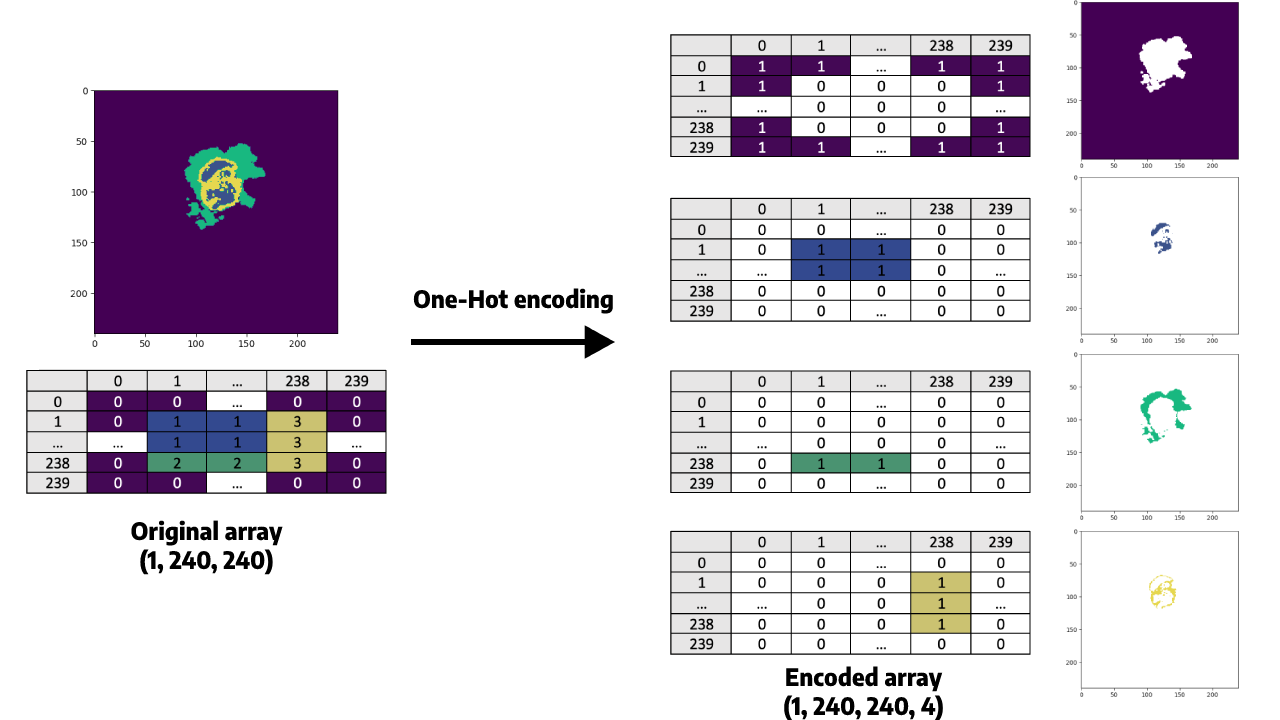

- **Resize each slice of our images from (240x240) to a (128, 128) shape**: Resizing slices from (240x240) to (128x128) is needed since we need image shapes that are a power of two (2<sup>n</sup>, where n is an integer). This is due to the fact that we will use pooling layers (MaxPooling2D) in our convolutional neural network (CNN), which reduce the spatial resolution by 2.

You may wonder why we didn't resize the images in a (256, 256) shape, which also is a power of 2 and is closer to 240 than 128 is.

This choice depends on several factors, such as the complexity of the model, the amount of training data, the computational resources available, and the desired balance between computational efficiency and information preservation.

Indeed, resizing images to (256, 256) may preserve more information than resizing to (128, 128), which could lead to better performance. However, this larger size also means that the model will have more parameters, which can increase the training time and memory requirements, which is the reason why we will choose the (128, 128) shape.

*Of course, you are free to train your model with (256, 256) images, but keep in mind you will have to adapt your U-Net architecture.*

In [ ]:
pip show keras tensorflow tensorflow-gpu

In [ ]:
import tensorflow as tf
print("===============================")
print(f'tensorflow version: {tf.__version__}')  # Should print 2.7.0
print(f'is built with CUDA: {tf.test.is_built_with_cuda()}')  # Should return True
print(f'GPU details: {tf.config.list_physical_devices("GPU")}')  # Should show GPU details

# Check if TensorFlow can detect a GPU
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

print("===============================")

In [ ]:
from tensorflow.keras import layers, models

# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
IMG_SIZE = 128

class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):
            
            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '-t1c.nii.gz'
            flair_path = sample_path + '-t2f.nii.gz'
            seg_path = sample_path + '-seg.nii.gz'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'
            
            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    
        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y
        
training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

**To summarize the preprocessing steps**:
- We use a data generator to be able to process and send our data to our neural network (since all our images cannot be stored in memory at once).
- For each epoch (single pass of the entire training dataset through a neural network), the model will receive 250 samples (those contained in our training dataset).
- For each sample, the model will have to analyze 150 slices (since there are two modalities, and 75 selected slices for both of them), received in a (128, 128) shape, as an X array of a (128, 128, 75, 2) shape. This array will be provided with the ground truth segmentation of the patient, which will be One-Hot encoded and will then have a (75, 128, 128, 4) shape.

### Step 5 - Define the model

Now that we can iterate on our data, we can define our segmentation model.

#### A - U-Net

We will use the [U-Net architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/). This [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network) is designed for biomedical image segmentation, and is particularly well-suited for segmentation tasks where the regions of interest are small and have complex shapes (such as tumors in MRI scans).

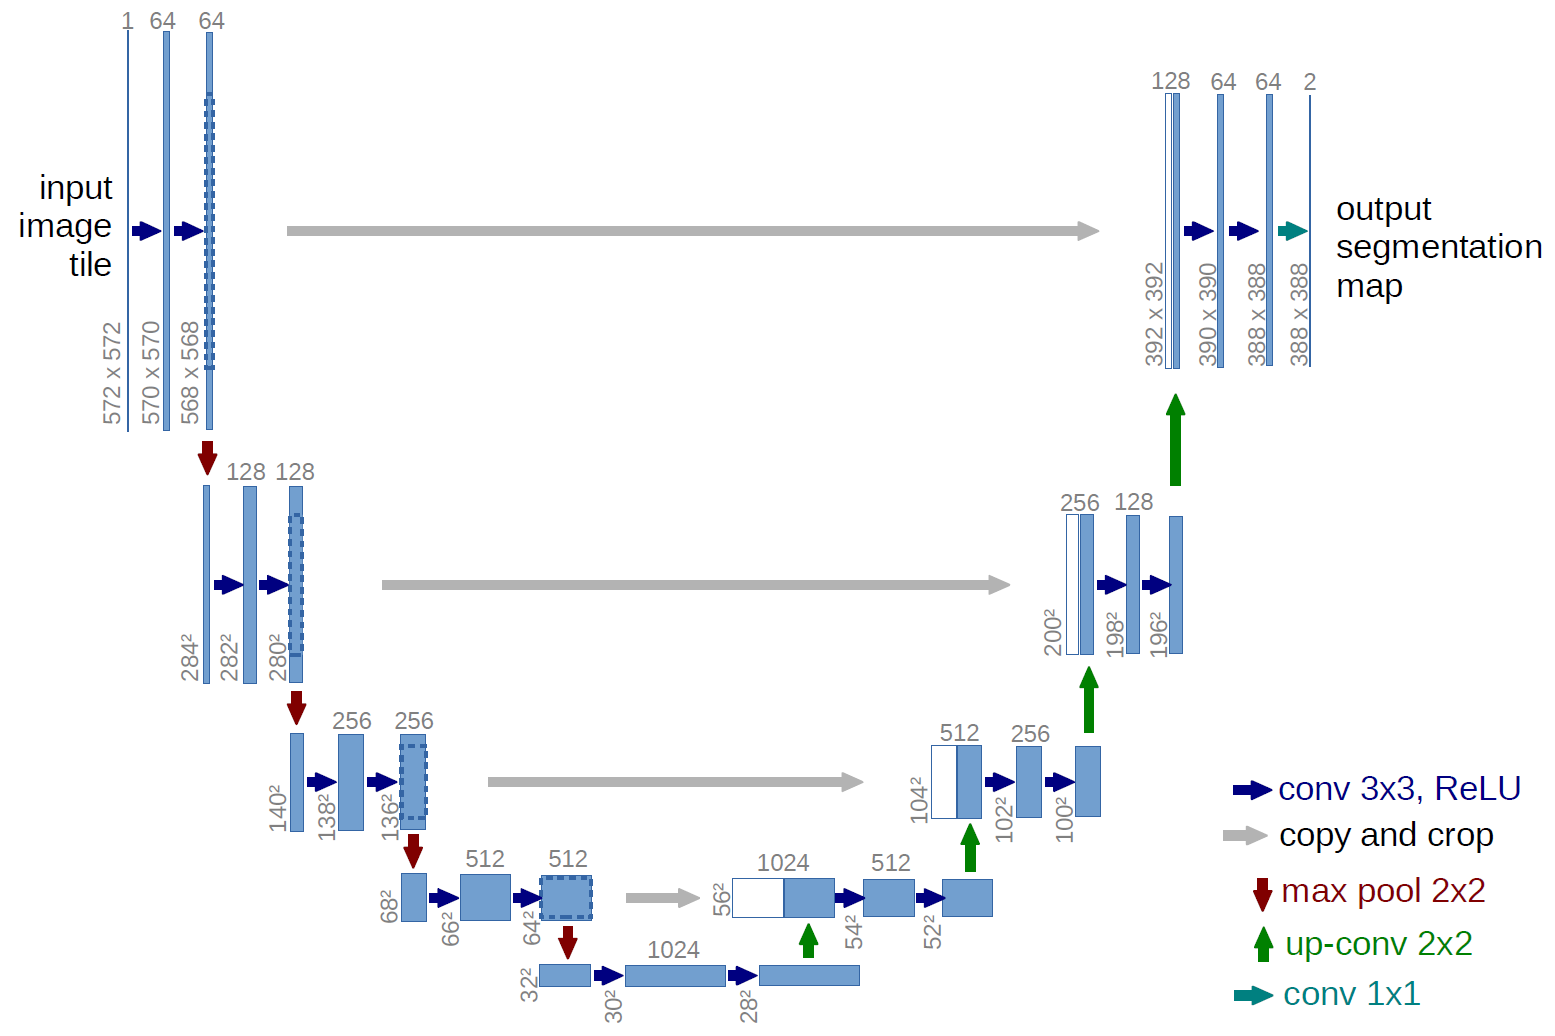

This neural network was first introduced in 2015 by *Olaf Ronneberger, Philipp Fischer, Thomas Brox* and reported in the paper *[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)*.

Since the BraTS2020 dataset consists of 3D images, where each consists of multiple 2D slices in three orthogonal planes, we have 2 possibilities. We can either use a 2D U-Net, or a 3D U-Net. 

In theory, a 3D U-Net is more adapted in our case. Indeed, a 3D U-Net can leverage the 3D spatial context of the images, which means it can reduce the risk of false positives and false negatives that can occur due to partial or incomplete information in individual 2D slices.

However, a 2D U-Net is faster and requires less memory than a 3D U-Net, which can be an advantage when working with large datasets or limited computational resources.

In practice, it is often useful to try both 2D and 3D U-Net architectures and compare their performance on the specific segmentation task.

In this tutorial, we will opt for a 2D neural network implementation:

In [ ]:
# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

#### B - Loss function

When training a CNN, it's important to choose a loss function that accurately reflects the performance of the network. Indeed, this function will allow to compare the predicted pixels to those of the ground truth for each patient. At each epoch, the goal is to update the weights of our model in a way that minimizes this loss function, and therefore improves the accuracy of its predictions.

A commonly used loss function for multi-class classification problems is **categorical cross-entropy**, which measures the difference between the predicted probability distribution of each pixel and the real value of the one-hot encoded ground truth. Note that segmentations models sometimes use the **dice loss** function as well.

#### C - Output activation function

To get this probability distribution over the different classes for each pixel, we apply a **softmax** activation function to the output layer of our neural network.

This means that during training, our CNN will adjust its weights to minimize our loss function, which compares predicted probabilities given by the softmax function with those of the ground truth segmentation.

#### D - Other metrics: 

It is also important to monitor the model's performance using evaluation metrics. 

We will of course use **accuracy**, which is a very popular measure. However, this metric can be misleading when working with imbalanced datasets like BraTS2020, where Background class is over represented. To address this issue, we will use other metrics such as the **intersection over union (IoU), the Dice coefficient, precision, sensitivity, and specificity**.

- **Accuracy**: Measures the overall proportion of correctly classified pixels, including both positive and negative pixels.

- **IoU**: Measures the overlap between the predicted and ground truth segmentations.

- **Sensitivity** (recall or true positive rate): Measures the proportion of positive ground truth pixels that were correctly predicted as positive.

- **Precision** (positive predictive value): Measures the proportion of predicted positive pixels that are actually positive.

- **Specificity** (true negative rate): Measures the proportion of negative ground truth pixels that were correctly predicted as negative.

In [ ]:
# Compute metric between the predicted segmentation and the ground truth
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

########################### my customized metrics ###########################

def sensibility(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    # Calculate the sensibility
    sensibility = 1 - (false_positives / (true_positives + possible_positives + K.epsilon()))
    # Check for NaN or Inf values and return NaN if True
    sensibility = tf.where(tf.math.is_nan(sensibility) | tf.math.is_inf(sensibility),
                           tf.constant(float('NaN')),
                           sensibility)
    return sensibility


def jaccard(y_true, y_pred):
    # True positives, false positives, false negatives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    # Calculate Jaccard index
    denominator = true_positives + false_positives + false_negatives + K.epsilon()  # Add epsilon to avoid division by zero
    result = true_positives / denominator
    # Handle NaN or Inf cases
    result = K.switch(K.is_inf(result) | K.is_nan(result), K.constant(float('NaN')), result)
    return result


# Hausdorff distance (approximation for use in Keras)
def hausdorff(y_true, y_pred):
    # Flatten the coordinates of the true and predicted segmentation masks
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    # Compute the Euclidean distance between every pair of points
    dist_matrix = K.square(y_true_flat - y_pred_flat)
    # Get the maximum distance in both directions (directed Hausdorff)
    directed_hausdorff_1 = K.max(dist_matrix, axis=1)  # From y_true to y_pred
    directed_hausdorff_2 = K.max(dist_matrix, axis=0)  # From y_pred to y_true
    # Take the maximum of both directed Hausdorff distances
    hausdorff_dist = K.maximum(directed_hausdorff_1, directed_hausdorff_2)
    # Handle NaN or Inf values by replacing them with NaN (if needed)
    hausdorff_dist = K.switch(K.is_inf(hausdorff_dist) | K.is_nan(hausdorff_dist), K.constant(float('NaN')), hausdorff_dist)
    return hausdorff_dist

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]  # Set limit to 8GB
        )
        print("Limited GPU memory usage to 8GB")
    except RuntimeError as e:
        print(e)

Virtual devices cannot be modified after being initialized


In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for i, gpu in enumerate(gpus):
        device_name = f"GPU:{i}"  # Properly format the device name
        details = tf.config.experimental.get_memory_info(device_name)
        print(f"GPU: {device_name}")
        print(f"Current Memory Usage: {details['current']} bytes")
        print(f"Peak Memory Usage: {details['peak']} bytes")
else:
    print("No GPU devices found.")

for gpu in gpus:
    print(f"Memory growth for {gpu}: {tf.config.experimental.get_memory_growth(gpu)}")

GPU: GPU:0
Current Memory Usage: 0 bytes
Peak Memory Usage: 0 bytes
Memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): None


#### E - Build the model

In [ ]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity ] )

#### F - Set up callbacks

Callbacks are functions that can be executed during the training process. 

We will use three callbacks:

- **ReduceLROnPlateau**: This callback reduces the learning rate when a metric has stopped improving (validation loss here). The learning rate is reduced by a factor of 0.2, the patience is set to 2 epochs, and the minimum learning rate is set to 0.000001.

- **ModelCheckpoint**: Saves the best model weights (model that has obtained the lowest validation loss during the different epochs). Saving a model allows us to reuse it later or to share it, without having to retrain it from scratch. This will save us time and resources!

- **CSVLogger**: Add metrics to a CSV file, which is named *training.log* (parameter `append` is set to `False` so the file is overwritten if it already exists). 

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
    
    keras.callbacks.ModelCheckpoint(filepath = './model/model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

### Step 6 - Train & Save the model

We are now ready to train our deep neural network using the *.fit()* method in Keras. We will pass our 3 callbacks to the method so they can be executed during the training process, which will last 35 epochs.

In [ ]:
model.fit(training_generator,
          epochs=100,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

### Download trained weights for future inference

Thanks to our callbacks, weight files will be generated and added to your notebook's environment during the training.

If you don't want to lose your training, or if you want to reuse the model for future inference, **I invite you to download your weights** from the File Browser, on the left of the notebook interface. **Make sure you download the two files of an epoch (`m5.data` and `m5.index` files)** to be able to reuse these weights.

Of course, it is legitimate to ask **which files to download? Which ones contain the best weights?** To answer these questions, we are going to analyze the scores obtained for each epoch.

### Metrics analysis

Now that the training has been completed, it's time to take a look at the CSVLogger callback, to get a better understanding of the training process and the performance of our model.

In [ ]:
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

axs[3].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
axs[3].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Mean IOU')
axs[3].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

*If the `mean_io_u` graph does not appear, I recommend that you display the `training.log` file, and retrieve the column name for the `mean_io_u` and the `val_mean_io_u` metrics. They can vary.*

On the accuracy graph, we can see that both training accuracy and validation accuracy are increasing over epochs and reaching a plateau. This indicates that the model is learning from the data and generalizing well to new one.
It does not seem that we are facing overfitting since both metrics are improving.

Then, we can see that our models is clearly learning from the training data, since both losses decrease over time on the second graph. We also notice that the best version of our model is reached around epoch 26 (we can also see it in the training logs). This conclusion is reinforced by the following graph, where both dice coefficients are increasing over epochs.

### Step 7 - Predict tumor segmentations

Now that our model is trained, it's time to use it to predict the segmentations in our test dataset! 

In general, we have two major possibilities:

- Use the best model's weights (from epoch 26)
- Use the final model's weights

Indeed, using the final model's weights does not necessarily mean that we will get the best performances, predictions on new, unseen data. 

In our case, there is no real difference between the two options, so the choice doesn't really matter. 

But for another case, you may be interested in a specific version of your model. You can load it with the following code:

In [ ]:
# Compile a model and load our saved weights
# IMG_SIZE = 128
# input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

# best_saved_model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

# best_saved_model.load_weights('model_.26-0.025329.m5')

Now, let's construct a function that allows us to predict the segmentation of a patient in the test dataset. I will choose a display in the axial plane, but we can totally choose another plane. 

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'
            
    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    
    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    # Send our images to the CNN model and return predicted segmentation 
    return model.predict(X/np.max(X), verbose=1)

We will call the predict_segmentation() function in the following one to predict the segmentation of a patient, plot it and compare it with the original one.

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)
    
    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')
    
    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')
    
    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')
    
    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')
    
    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

#### Plot Random predictions & Compare with Original (Ground truth) 

In [ ]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

In [ ]:
show_predicted_segmentations(samples_test, 50, cmap, norm)

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

As you can see, predicted segmentations are quite accurate. 

Unfortunately, we have some **false positives**, which means that we detect a tumor when there is none originally present *(cf 3rd plot, patient 266,  slice 70)*. 

In a field like medical analysis, this is kind of embarrassing. Imagine an AI telling you that you have a tumor, even though you are healthy. This can lead to unnecessary treatments, which can have negative effects on your health and quality of life.

Here are some ways to solve this problem: 

- **Neural Network**: Maybe change the model architecture, try a 3D CNN.

- **Dataset**: Train the model on a larger dataset

- **Modalities & slices**: Perhaps choose other or different modalities than the ones we used. Select more slices or a different slices range for the model training.

- **Post-processing techniques**: Argmax decoding, Thresholding, Morphological operations like erosion / dilatation to refine the predicted segmentations. Indeed, we notice that the errors are very little visible. A post processing could therefore eliminate them.

#### Post-processing

We are going to use the argmax decoding technique. This process consists in applying the argmax function to obtain a single label for each pixel, corresponding to the class with the highest probability. Indeed, our pixels currently have probability values for each class since they were obtained using the softmax activation function. 

This will also allow us to have the same display colors between the original segmentation and the prediction, which will be easier to compare than just above.

We will perform these techniques on the same patients as before. This will allow to see if the correct predictions are kept, and if the false positive predictions are removed!

In [ ]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):
    
    # Get path of this patient
    sample_path = os.path.join(data_path, sample, sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3
    
    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan
    
    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4] 
    
    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')
    
    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)
    
    plt.show()

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=70, cmap=cmap, norm=norm)

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=70, cmap=cmap, norm=norm)

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_274", slice_to_plot=70, cmap=cmap, norm=norm)

The argmax decoding technique seems to work pretty well! Indeed, the false positive *(cf 3rd plot, patient_266, slice 70)* was removed with post-processing and the other predictions were well preserved! 

### Step 8 - Evaluate the model
To finish, let's call the evaluate() function to evaluate the performance of our model on our test dataset.

In [ ]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

We can conclude that the model performed very well on the test dataset, achieving a **low test loss (0.0206)**, a **correct dice coefficient (0.6008) for an image segmentation task**, and **good scores on other metrics** which indicate that the model has good generalization performance on unseen data.

## Conclusion 

I hope you have enjoyed this tutorial!

You are now more comfortable with image segmentation! 

Keep in mind that even if our results seem accurate, we have some false positive in our predictions. In a field like medical imaging, it is crucial to evaluate the balance between true positives and false positives and assess the risks and benefits of an artificial approach. 

As we have seen, post-processing techniques can be used to solve this problem. However, we must be careful with the results of these methods.

You can check our next tutorials about computer vision to learn how to:

- [Use Transfer Learning with ResNet50 for image classification](https://github.com/ovh/ai-training-examples/blob/main/notebooks/computer-vision/image-classification/tensorflow/resnet50/notebook-resnet-transfer-learning-image-classification.ipynb)

- [Train YOLOv7 for American Sign Language recognition](https://github.com/ovh/ai-training-examples/blob/main/notebooks/computer-vision/object-detection/miniconda/yolov7/notebook_object_detection_yolov7_asl.ipynb)


#### References
- [Article, U-Net Implementation for BraTS 2019 by Naomi Fridman](https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a)

- [Notebook, 3D MRI Brain tumor segmentation, by Rastislav](https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net)

- [The BraTS2020 Challenge](https://www.med.upenn.edu/cbica/brats2020/)

#### Papers
- [Information about the U-Net model, proposed by Ronneberger in 2015](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

- [Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features, Nature Scientific Data, S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J.S. Kirby, et al](https://pubmed.ncbi.nlm.nih.gov/28872634/)

- [Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge, S. Bakas, M. Reyes, A. Jakab, S. Bauer, M. Rempfler, A. Crimi, et al](https://arxiv.org/abs/1811.02629)

- [The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS), IEEE Transactions on Medical Imaging, B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al](https://pubmed.ncbi.nlm.nih.gov/25494501/)

#### Sources 
- [Image, Image segmentation, Wikipedia Commons](https://commons.wikimedia.org/wiki/File:Image_segmentation.png)

- [Image, Planes of Body, Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Planes_of_Body.jpg)